In [1]:
import numpy as np
# from scipy import pi, exp
#######################################
# Experimental Setup
# Slit width = 2*sigma
# mean position x0,y0,z0
# Normalization : Norm = 1/((2*pi*sigma*sigma)**(0.25))
######################################


def psi0(x, y, z, x0, y0, z0, sigma=0.5, k=15*np.pi):
    Norm1D = 1/((2*np.pi*sigma*sigma)**(0.25))
    Norm3D = Norm1D*Norm1D*Norm1D
    # print (Norm3D)
    """
    Proposed wave function for the initial time t=0.
    Using NumPy arrays for calculations.
    """
    #return np.exp(-1/2*((y-y0)**2 + (z-z0)**2 + (x-x0)**2)/sigma**2)*np.exp(1j*k*(x-x0)) # originally Shounak
    return Norm3D*np.exp(-1/4*((y-y0)**2 + (z-z0)**2 + (x-x0)**2)/sigma**2)*np.exp(1j*k*(x-x0))

# def doubleSlit_interaction(psi, i0, i1, j0, j1, j2, j3, k0, k1):

#     """
#     Double slit interaction using NumPy arrays for calculations.
#     """

#     psi = cp.asarray(psi)  # Ensure psi is a NumPy array

#     psi[i0:i1, :j0, :] = 0
#     psi[i0:i1, j0:j1, :k0] = 0
#     psi[i0:i1, j0:j1, k1:] = 0
#     psi[i0:i1, j1:j2, :] = 0
#     psi[i0:i1, j2:j3, :k0] = 0
#     psi[i0:i1, j2:j3, k1:] = 0
#     psi[i0:i1, j3:, :] = 0

#     return psi


def doubleSlit_interaction(psi, i0, i1, inner_radius1):
    """
    Apply concentric annular slits (rings) to a wavefunction represented by a CuPy array
    within a specified range along the x-axis.

    Args:
        psi (cupy.ndarray): Input wavefunction array of shape (size_x, size_y, size_z).
        i0 (int): Starting index along the x-axis to apply the annular slits.
        i1 (int): Ending index (exclusive) along the x-axis to apply the annular slits.
        inner_radius1 (int): Inner radius of the first annular slit along the y-z plane.
        outer_radius1 (int): Outer radius of the first annular slit along the y-z plane.
        inner_radius2 (int): Inner radius of the second annular slit along the y-z plane.
        outer_radius2 (int): Outer radius of the second annular slit along the y-z plane.

    Returns:
        cupy.ndarray: Modified wavefunction array with annular slits applied within the specified x-range.
    """
    # Ensure psi is a CuPy array
    psi = cp.asarray(psi)

    # Get the shape of the psi array
    size_x, size_y, size_z = psi.shape

    # Calculate distance from the center for each point in the 3D array along the y-axis and z-axis
    y_indices, z_indices = cp.ogrid[:size_y, :size_z]
    distance_to_center = cp.sqrt((y_indices - size_y // 2)**2 +
                                 (z_indices - size_z // 2)**2)

    # print(distance_to_center.shape)
    # Create masks for the annular slit regions based on y-z plane distances
    mask1 = distance_to_center >= inner_radius1


    n=i1-i0
    # Expand masks to match the dimensions of the psi array along the x-axis
    stacked_mask1 = cp.tile(mask1, (n, 1, 1))  # Shape: (1, size_y, size_z)



    # Create a slice for the x-axis range to apply the annular slits
    x_slice = slice(i0, i1)  # Slice along the x-axis from i0 to i1 (exclusive)
    print("slice",psi[x_slice, :, :].shape)
    # Apply the annular slit masks to the specified x-range within the psi array
    combined_mask = stacked_mask1
    psi[x_slice, :, :][combined_mask] = 0

    return psi




# Now you can use these functions with NumPy arrays and SciPy!


In [2]:
import numpy as np
L = 8 # Well of width L. Shafts from 0 to +L.
Dy = 0.4 # Spatial step size. # Dy= Dz=Dx
Dt = Dy**2/4 # Temporal step size.
Nx = int(L/Dy) + 1 # Number of points on the x axis.
Ny = int(L/Dy) + 1 # Number of points on the y axis.
Nz = int(L/Dy) + 1 # Number of points on the z axis.

Nt = 40 # Number of time steps.
rx = -Dt/(2j*Dy**2) # Constant to simplify expressions.
ry = -Dt/(2j*Dy**2) # Constant to simplify expressions.
rz = -Dt/(2j*Dy**2) # Constant to simplify expressions.
a = 1 + 2*rx + 2*ry
b = 1 - 2*rx - 2*ry
# Initial position of the center of the Gaussian wave function.
x0 = L/5
y0 = L/2
z0 = L/2
# Parameters of the double slit. Rectangular Slit
w = 0.2 # Width of the walls of the double slit.
b = 2 # Breadth of the double slit.
s = 0.8 # Separation between the edges of the slits.
a = 0.4 # Aperture of the slits.

# Indices that parameterize the double slit in the space of points.
# Horizontal axis.
i0 = int(1/(2*Dy)*(L-w)) # Left edge.
i1 = int(1/(2*Dy)*(L+w)) # Right edge.
# # Eje vertical.
# j3 = int(1/(2*Dy)*(L+s) + a/Dy) # Lower edge of the lower slit.
# j2 = int(1/(2*Dy)*(L+s))        # Upper edge of the lower slit.
# j1 = int(1/(2*Dy)*(L-s))        # Lower edge of the upper slit.
# j0 = int(1/(2*Dy)*(L-s) - a/Dy) # Upper edge of the upper slit.

# k0 = int(1/(2*Dy)*(L-b))
# k1 = int(1/(2*Dy)*(L+b))

# inner_radius1 = int(L/(16*Dy))
inner_radius1 = int(2/Dy)


# print(i0,i1,j0,j1,j2,j3,k0,k1)
v = np.zeros((Nx,Ny,Nz), complex) # Potential.
Ni = (Nx-2)*(Ny-2)*(Nz-2)  # Number of unknown factors v[i,j], i = 1,...,Nx-2, j = 1,...,Ny-2
print(Nx,Ny,Nz,Ni)


21 21 21 6859


In [3]:
import cupy as cp
import cupyx.scipy.sparse as sparse

# Assuming `Nx`, `Ny`, and `Nz` are already Cupy arrays if not convert them
# Nx = cp.array(Nx)
# Ny = cp.array(Ny)
# Nz = cp.array(Nz)
A = 1 + 2*rx + 2*ry + 2*rz#+ 1j*Dt/2*v[k,k,k]
B = 1 - 2*rx - 2*ry -2*rz#+ 1j*Dt/2*v[k,k,k]

diag = cp.ones([Ni])
diags1 = cp.array([-rx*diag, -ry*diag, -rz*diag, A*diag, -rz*diag, -ry*diag, -rx*diag])
diags2 = cp.array([rx*diag, ry*diag, rz*diag, B*diag, rz*diag, ry*diag, rx*diag])

# Construct sparse matrices
A = sparse.spdiags(diags1, cp.array([-(Nx-2)*(Nx-2), -(Nx-2), -1, 0, 1, (Nx-2), (Nx-2)*(Nx-2)]), Ni, Ni)
M = sparse.spdiags(diags2, cp.array([-(Nx-2)*(Nx-2), -(Nx-2), -1, 0, 1, (Nx-2), (Nx-2)*(Nx-2)]), Ni, Ni)

print(A.shape)
print(M.shape)


(6859, 6859)
(6859, 6859)


In [4]:
print(type(A))

<class 'cupyx.scipy.sparse._dia.dia_matrix'>


In [5]:
# import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

A = A.tocsr()
M = M.tocsr()
# M = torch.sparse_coo_tensor(indices=torch.tensor([M.row, M.col]), values=torch.tensor(M.data), size=M.shape).to(device)
# A = torch.sparse_coo_tensor(indices=torch.tensor([A.row, A.col]), values=torch.tensor(A.data), size=A.shape).to(device)

In [6]:
type(A)

cupyx.scipy.sparse._csr.csr_matrix

In [7]:
# import cupy as cp
from cupyx.scipy.sparse.linalg import spsolve
from cupy.sparse import csr_matrix

# Assuming A and M are scipy.sparse._dia.dia_matrix
# A = dia_matrix(...)
# M = dia_matrix(...)

# Crate tensors for x, y, z
x = cp.linspace(0, L, Ny-2)  # Array of spatial points.
y = cp.linspace(0, L, Ny-2)  # Array of spatial points.
z = cp.linspace(0, L, Ny-2)  # Array of spatial points.

# Create 3D meshgrid
X, Y, Z = cp.meshgrid(x, y, z,indexing='ij')

# Initialize psis and psi
psis = []  # To store the wave function at each time step.
psi = psi0(X, Y, Z, x0, y0, z0)  # Initialize the wave function with the Gaussian.
print("psi0",type(psi))
psi[0, :, :], psi[-1, :, :], psi[:, 0, :], psi[:, -1, :], psi[:, :, 0], psi[:, :, -1] = 0, 0, 0, 0, 0, 0  # Set boundaries to zero
psi = doubleSlit_interaction(psi, i0, i1, inner_radius1) # apply Psi=0 on mask
psis.append(psi)  # Store the wave function of this time step

for i in range(1, Nt):
    # print(type(psi))
    psi_vect = psi.reshape(Ni)
    # print(type(M),type(psi_vect),type(psi_vect[0]))
    # print(psi_vect.shape,M.shape,psi_vect[0].shape)
    psi_vect = cp.array(psi_vect)
    print(psi_vect.shape)
    b = M.dot(psi_vect) # Calculate the array of independent terms
    # print("b.shape:", b.shape)  # Print shape of the result
    psi_vect = spsolve(A, b)  # Solve the system for this temporal step
    psi = psi_vect.reshape(Nx-2, Ny-2, Nz-2)  # Reshape the array to the shape of the wave function
    psi = doubleSlit_interaction(psi, i0, i1, inner_radius1) # apply Psi=0 on mask
    psis.append(psi)  # Save the result
    print(i*100/Nt)


# Calculate the modulus of the wave function at each time step
mod_psis = [abs(wavefunc) for wavefunc in psis]


psi0 <class 'cupy.ndarray'>
slice (1, 19, 19)
(6859,)
slice (1, 19, 19)
2.5
(6859,)
slice (1, 19, 19)
5.0
(6859,)
slice (1, 19, 19)
7.5
(6859,)
slice (1, 19, 19)
10.0
(6859,)
slice (1, 19, 19)
12.5
(6859,)
slice (1, 19, 19)
15.0
(6859,)
slice (1, 19, 19)
17.5
(6859,)
slice (1, 19, 19)
20.0
(6859,)
slice (1, 19, 19)
22.5
(6859,)
slice (1, 19, 19)
25.0
(6859,)
slice (1, 19, 19)
27.5
(6859,)
slice (1, 19, 19)
30.0
(6859,)
slice (1, 19, 19)
32.5
(6859,)
slice (1, 19, 19)
35.0
(6859,)
slice (1, 19, 19)
37.5
(6859,)
slice (1, 19, 19)
40.0
(6859,)
slice (1, 19, 19)
42.5
(6859,)
slice (1, 19, 19)
45.0
(6859,)
slice (1, 19, 19)
47.5
(6859,)
slice (1, 19, 19)
50.0
(6859,)
slice (1, 19, 19)
52.5
(6859,)
slice (1, 19, 19)
55.0
(6859,)
slice (1, 19, 19)
57.5
(6859,)
slice (1, 19, 19)
60.0
(6859,)
slice (1, 19, 19)
62.5
(6859,)
slice (1, 19, 19)
65.0
(6859,)
slice (1, 19, 19)
67.5
(6859,)
slice (1, 19, 19)
70.0
(6859,)
slice (1, 19, 19)
72.5
(6859,)
slice (1, 19, 19)
75.0
(6859,)
slice (1, 19, 19)
7

In [8]:
# print(A.shape,A[i].shape)
# for i in range(0,Ni):
#     for j in range(0,Ni):
#         print(A[i,j],end=' ')
#     print()

In [9]:
type(mod_psis)

list

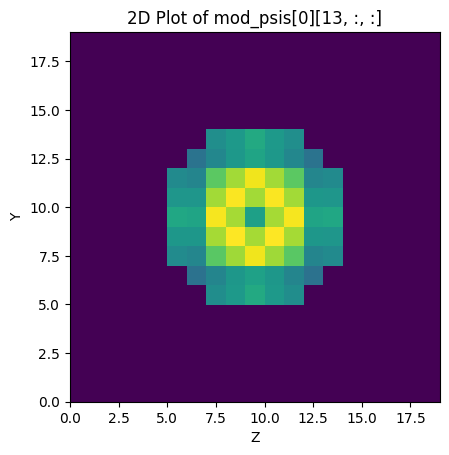

In [10]:
# Print the values in the specified format
# for it in mod_psis:
#     for j in range(0, it.shape[0]):
#         for k in range(0, it.shape[1]):
#             print(it[13, j, k], end=' ')
#         print()
#     print("done")
import matplotlib.pyplot as plt
# Create a 2D plot
fig, ax = plt.subplots()
ax.imshow(mod_psis[30][9, :, :].get(), cmap='viridis', origin='lower', extent=(0, mod_psis[0].shape[1], 0, mod_psis[0].shape[0]))
ax.set_xlabel('Z')
ax.set_ylabel('Y')
ax.set_title('2D Plot of mod_psis[0][13, :, :]')

plt.show()

In [11]:
psis_numpy = [arr.get() for arr in psis]

# Save the list of NumPy arrays to a file
np.save('data_array.npy', psis_numpy)

In [12]:
loaded_array_list = np.load('data_array.npy', allow_pickle=True)

In [13]:
new_mod_psis = [abs(wavefunc) for wavefunc in loaded_array_list]

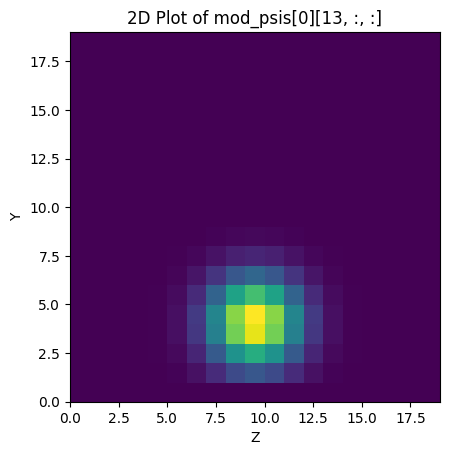

In [14]:
import matplotlib.pyplot as plt
# Create a 2D plot
fig, ax = plt.subplots()
ax.imshow(new_mod_psis[0][:, 16, :], cmap='viridis', origin='lower', extent=(0, mod_psis[0].shape[1], 0, mod_psis[0].shape[0]))
ax.set_xlabel('Z')
ax.set_ylabel('Y')
ax.set_title('2D Plot of mod_psis[0][13, :, :]')

plt.show()

[[3.6, 4.4, 4.4], [3.6, 4.42, 4.42], [3.6, 4.44, 4.44], [3.6, 4.46, 4.46], [3.6, 4.48, 4.48], [3.6, 4.5, 4.5], [3.6, 4.5200000000000005, 4.5200000000000005], [3.6, 4.54, 4.54], [3.6, 4.5600000000000005, 4.5600000000000005], [3.6, 4.58, 4.58], [3.6, 4.6000000000000005, 4.6000000000000005], [3.6, 4.62, 4.62], [3.6, 4.640000000000001, 4.640000000000001], [3.6, 4.66, 4.66], [3.6, 4.680000000000001, 4.680000000000001], [3.6, 4.7, 4.7], [3.6, 4.720000000000001, 4.720000000000001], [3.6, 4.74, 4.74], [3.6, 4.760000000000001, 4.760000000000001], [3.6, 4.78, 4.78], [3.6, 3.22, 3.22], [3.6, 3.24, 3.24], [3.6, 3.2600000000000002, 3.2600000000000002], [3.6, 3.2800000000000002, 3.2800000000000002], [3.6, 3.3000000000000003, 3.3000000000000003], [3.6, 3.3200000000000003, 3.3200000000000003], [3.6, 3.34, 3.34], [3.6, 3.36, 3.36], [3.6, 3.38, 3.38], [3.6, 3.4, 3.4], [3.6, 3.42, 3.42], [3.6, 3.44, 3.44], [3.6, 3.46, 3.46], [3.6, 3.48, 3.48], [3.6, 3.5, 3.5], [3.6, 3.52, 3.52], [3.6, 3.54, 3.54], [3.6, 

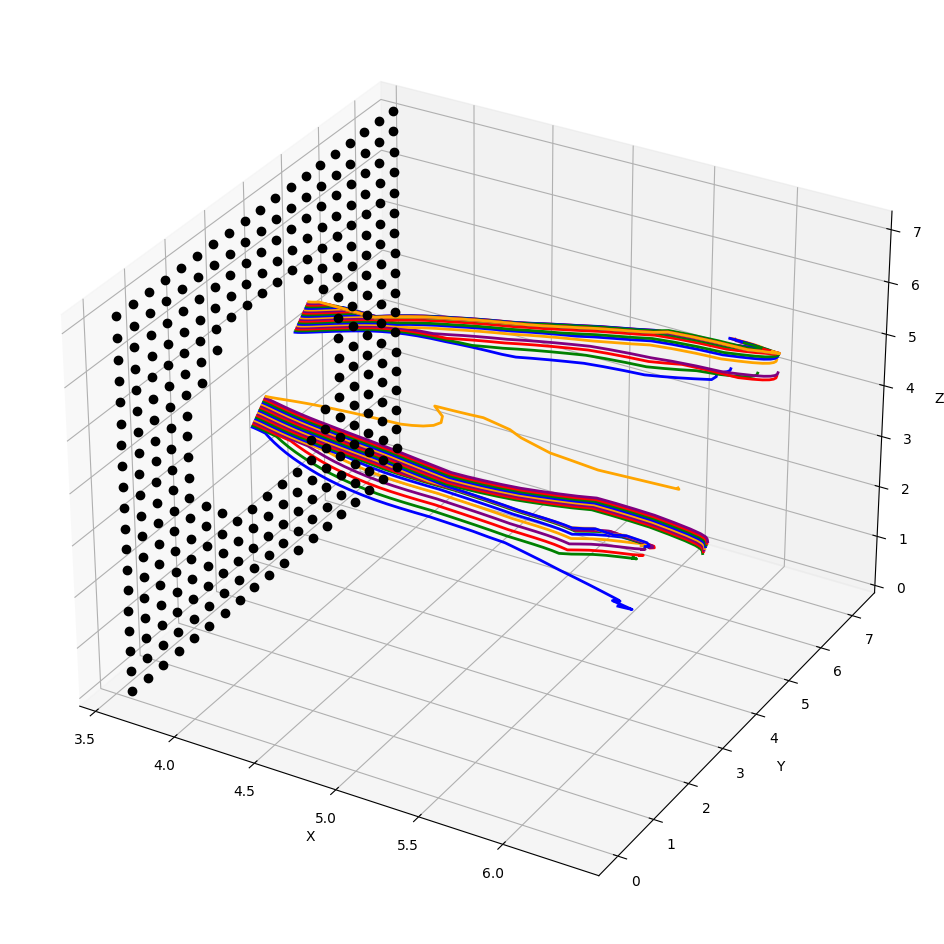

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cupy

# Initialize particle positions (assuming L is defined)
num_particles = 40 # Replace with the actual number of particles
# particle_position = [[3*L/8, L/4], [3*L/8, 2*L/4], [3*L/8, 3*L/4]]
particle_position = []
e=1e-20
num_per_half = int(num_particles / 2)
half_L = L / 2
half_s = s / 2

# half_L = half_L - .02
# half_s = half_s + .02
# Filling particles between L/2 + s/2 and L/2 + s/2 + a
for i in range(num_per_half):
    y_pos = half_L + half_s + (i * a) / num_per_half
    particle_position.append([i0*Dy, y_pos,y_pos])

# Filling particles between L/2 - s/2 and L/2 - s/2 - a (reverse order for symmetry)
for i in range(num_per_half - 1, -1, -1):
    y_pos = half_L - half_s - (i * a) / num_per_half
    particle_position.append([i0*Dy, y_pos,y_pos])




    # particle_position[i][1] = i*L/(num_particles)
# Assuming psis is defined elsewhere and contains wavefunction values
print(particle_position)
# Dictionaries to store particle positions (generalized)
particle_data = {i: {'x': [], 'y': [], 'z': []} for i in range(num_particles)}
# Simulate particle movement
for wavefunc in psis:
    for l, particle in enumerate(particle_position):
        # print(wavefunc.shape)
        i = int(particle[0] / Dy)
        j = int(particle[1] / Dy)
        k = int(particle[2] / Dy)

        # print("no",i,j)
        if(i<0 or j<0):
            continue

        elif(i<=17 and j<=17 and k<=17):
            Rx = (wavefunc[i + 1, j, k] - wavefunc[i, j, k]) / Dy
            Ry = (wavefunc[i, j + 1, k] - wavefunc[i, j, k]) / Dy
            Rz = (wavefunc[i, j, k + 1] - wavefunc[i, j, k]) / Dy
        else:
            continue

        if(wavefunc[i,j,k]==0):
            continue


            # Calculate force using valid indices


        Rx = Rx / (wavefunc[i, j, k] + e)
        Ry = Ry / (wavefunc[i, j, k] + e)
        Rz = Rz / (wavefunc[i, j, k] + e)
        # print(wavefunc[i,j])
        # if (wavefunc[i,j]==0):
        #     print(0)

        Rx = Dt * Rx.imag
        Ry = Dt * Ry.imag
        Rz = Dt * Rz.imag
        # print(particle[0],particle[1],Ry)
        particle[0] += Rx
        particle[1] += Ry
        particle[2] += Rz

        # Append positions to dictionaries
        particle_data[l]['x'].append(cupy.asnumpy(particle[0]))
        particle_data[l]['y'].append(cupy.asnumpy(particle[1]))
        particle_data[l]['z'].append(cupy.asnumpy(particle[2]))


# Uncomment the following section for plotting particle movement

# Plot particle movement with different colors
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Adjust colors as needed
fig = plt.figure(figsize=(12, 12))  # Set figure size for better visualization
ax = fig.add_subplot(111, projection='3d')


# Loop through particle data and plot trajectories
for i, particle in particle_data.items():
    label = f'Particle {i+1}'  # Adjust label format if needed
    plt.plot(particle['x'], particle['y'], particle['z'], label=label, color=colors[i % len(colors)], linewidth=2)  # Plot in 3D with z-coordinates



for i in range(i0,i1):
  for j in range(psis[0].shape[1]):
    for k in range(psis[0].shape[2]):
      if (psis[0][i, j, k] == 0):
          plt.plot(i * Dy, j * Dy, k * Dy, color='black', marker='o')  # Use marker for better visibility

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')  # Add label for z-axis

# plt.legend()
plt.show()

